In [1]:
using LinearAlgebra
using Kronecker
using Plots
using Plots.Measures

In [2]:
spin(k, i) = 2*((k >> i) & 1) - 1

function tfim_hamiltonian(N::Unsigned, J::Real, B::Real)
    Hamiltonian = zeros(Float64, 2^N, 2^N)
    for Ket = 0:(2^N - 1)
        if N > 1
            Diagonal = sum(spin(Ket, SpinIndex) * spin(Ket, mod(SpinIndex+1, 0:(N-1))) 
                           for SpinIndex = 0:(N - 1))
            Hamiltonian[Ket+1, Ket+1] = -J * Diagonal
        end
        
        for SpinIndex = 0:(N - 1)
            bit = 2 ^ SpinIndex
            Bra = Ket ⊻ bit
            Hamiltonian[Bra+1, Ket+1] = -B
        end
    end
    Hermitian(Hamiltonian)
end
tfim_hamiltonian(N::Integer, J::Real, B::Real) = tfim_hamiltonian(Unsigned(N), J, B)

tfim_hamiltonian (generic function with 2 methods)

In [3]:
expectation(O, ϕ) = ϕ' * O * ϕ
function power_iter(H, sX, sZ, gs, ts, projector, nsteps=25)
    energies = [expectation(H, ts)]
    xs = [expectation(sX, ts)]
    zs = [expectation(sZ, ts)]
    overlaps = [abs(gs' * ts)]
    
    phi = normalize(ts)
    for i in 1:nsteps
        phi = normalize(projector * phi)
        append!(energies, expectation(H, phi))
        append!(xs, expectation(sX, phi))
        append!(zs, expectation(sZ, phi))
        append!(overlaps, abs(gs' * phi))
    end

    return energies, xs, zs, overlaps
end

power_iter (generic function with 2 methods)

In [4]:
function plot_tfim_convergence(N, J, h; nsteps=25)
    H = tfim_hamiltonian(N, J, h)
    
    V, U = eigen(H)
    # V[2] = V[1]  # explicitly enforce ground state degeneracy
    # H = Hermitian(U' * diagm(V) * U);
    
    @show V[1:5]
    E0 = V[1]
    ψ = U[:, 1]
    
    X = [0 1; 1 0]
    Z = [1 0; 0 -1]

    sumX = Matrix(kroneckersum([X for _ in 1:N]...))
    sumZ = Matrix(kroneckersum([Z for _ in 1:N]...))
    
    X0 = expectation(sumX, ψ)
    Z0 = expectation(sumZ, ψ)
    expH = exp(-H);
    
    ϕ = kron([[1, 1]/sqrt(2) for _ in 1:10]...)
    
    phi_energies, phi_xs, phi_zs, phi_overlaps = power_iter(H, sumX, sumZ, ψ, ϕ, H, nsteps)
    exp_energies, exp_xs, exp_zs, exp_overlaps = power_iter(H, sumX, sumZ, ψ, ϕ, expH, nsteps);
    
    
    layout = @layout [t{0.01h}; a b; c d]
    p1 = plot(phi_overlaps, label="H", legend=:best)
    plot!(p1, exp_overlaps, label="exp")
    title!(p1, "fidelity")

    p2 = plot((@. (abs(phi_energies - E0))), label="H", legend=nothing)
    plot!(p2, (@. (abs(exp_energies - E0))), label="exp")
    title!("abs error of energy")

    p3 = plot((@. (abs(phi_xs - X0))), label="H", legend=nothing)
    plot!(p3, (@. (abs(exp_xs - X0))), label="exp")
    title!("abs error of X mag")

    p4 = plot((@. (abs(phi_zs - Z0))), label="H")
    plot!(p4, (@. (abs(exp_zs - Z0))), label="exp")
    title!("abs error of Z mag")

    p_header = plot(title="TFIM($N, J=$J, h=$h)",
                    framestyle=nothing,showaxis=false,xticks=false,yticks=false,margin=0mm)

    plot(p_header, p1, p3, p2, p4, layout = layout, fmt=:png, size=(1000,600))
end

plot_tfim_convergence (generic function with 1 method)

V[1:5] = [-10.100252558507007, -10.100252521184569, -6.851677748577116, -6.807452234972376, -6.807452234972376]


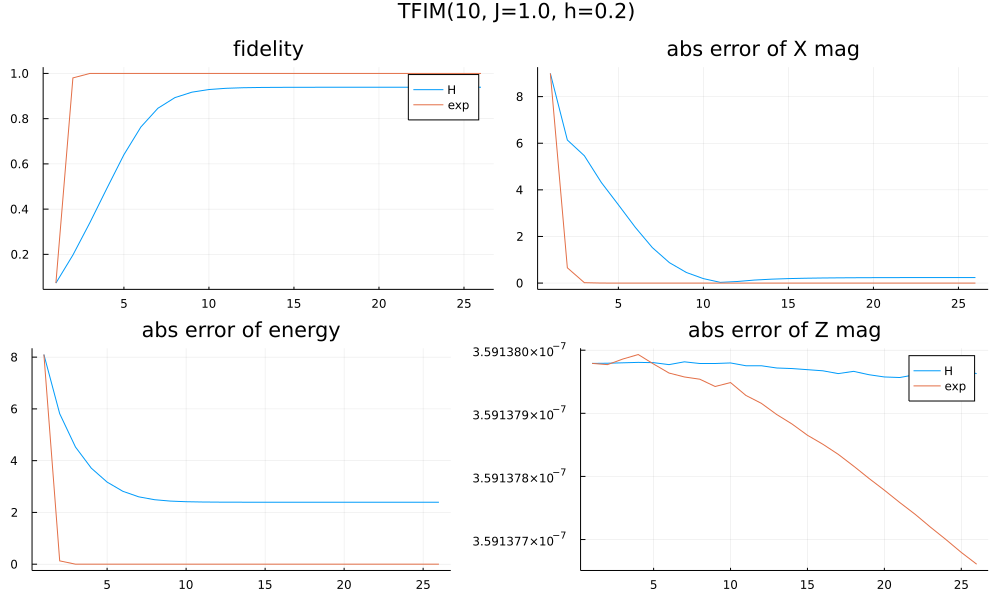

In [5]:
plot_tfim_convergence(10, 1.0, 0.2; nsteps=25)

V[1:5] = [-10.63560440934797, -10.635283682667284, -8.448575433939196, -8.307152656563229, -8.307152656563227]


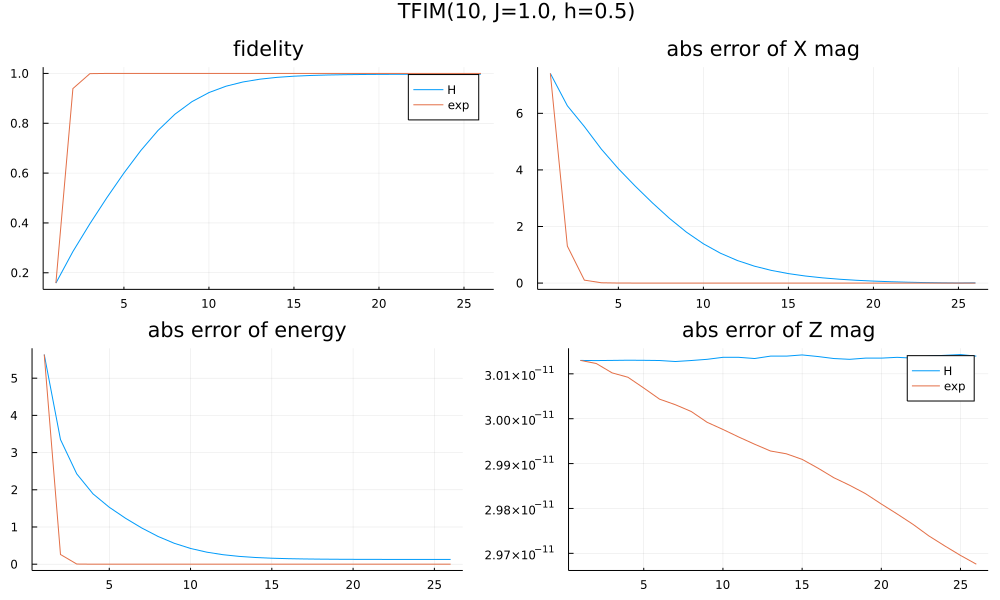

In [6]:
plot_tfim_convergence(10, 1.0, 0.5; nsteps=25)

V[1:5] = [-12.784906442999324, -12.627503029350086, -11.533430722677478, -11.391435051850296, -11.391435051850292]


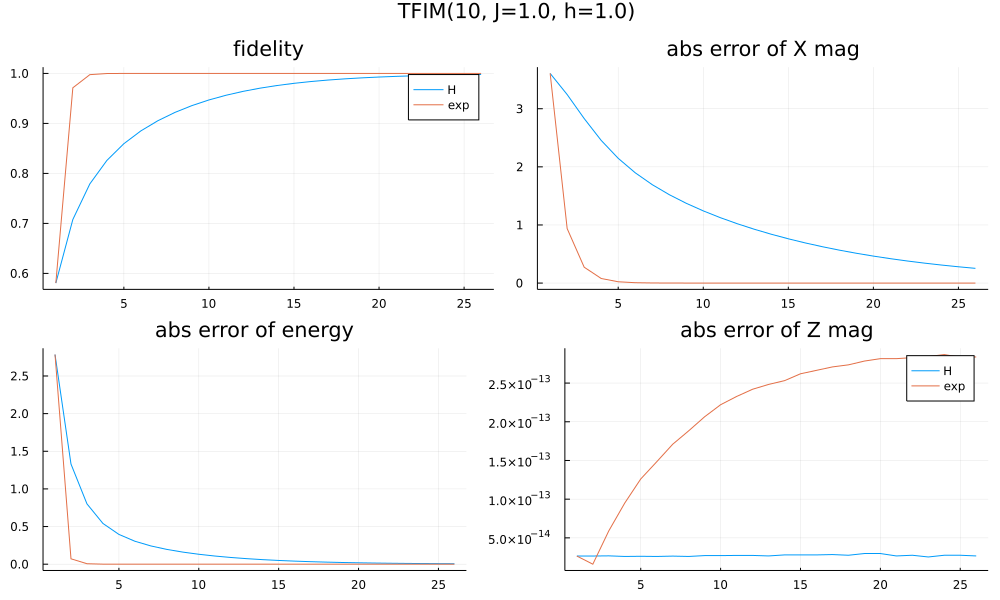

In [7]:
plot_tfim_convergence(10, 1.0, 1.0; nsteps=25)

V[1:5] = [-16.723024913948432, -15.715455069836977, -14.901124320634775, -14.901124320634775, -14.20324571373413]


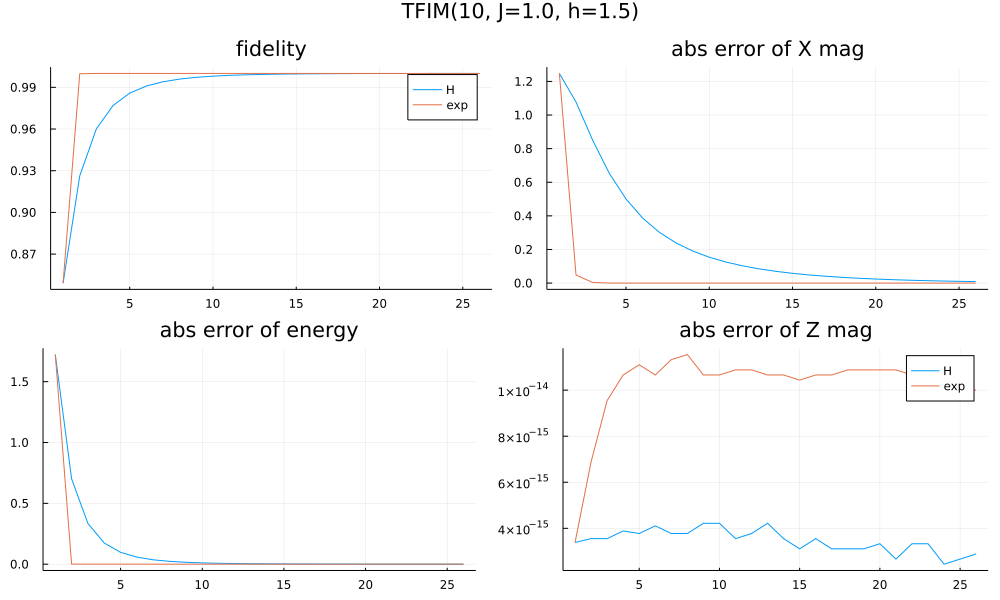

In [8]:
plot_tfim_convergence(10, 1.0, 1.5; nsteps=25)